In [32]:
from Bio import SeqIO, SearchIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, matthews_corrcoef, plot_confusion_matrix, accuracy_score
from scipy.special import expit

In [33]:
def get_domain(path_positives = '../data/kunitz_noseed.fasta',
               path_negatives = '../data/notkunitz.fasta',
               type = 'fasta'):
    domain = {}
    for record in SeqIO.parse(path_positives, type):
        record_id = record.id.split('|')[1]
        domain[record_id] = 1
    for record in SeqIO.parse(path_negatives, type):
        record_id = record.id.split('|')[1]
        domain[record_id] = 0
    return domain
domain = get_domain()

In [34]:
def get_evalue_hit(path = '../data/results_full.out',
                   type = 'hmmer3-tab'):
    results = SearchIO.read(path, type)
    evalue_hit = {}
    for hit in results:
        hit.id = hit.id.split('|')[1]
        evalue_hit[hit.id] = hit.evalue
    return evalue_hit
evalue_hit = get_evalue_hit()

In [35]:
def get_evalue_domain(path = '../data/results_full.out',
                      type = 'hmmer3-tab'):
    results = SearchIO.read(path, type)
    evalue_domain = {}
    for hit in results: 
        hit.id = hit.id.split('|')[1]
        best_hsp = hit[0]
        evalue_domain[hit.id]= best_hsp.evalue
    return evalue_domain
evalue_domain = get_evalue_domain()

In [36]:
def build_dataset(evalue_hit, evalue_domain, domain):
    dataset = pd.DataFrame({'Evalue hit': evalue_hit,
                            'Evalue best domain': evalue_domain,
                            'Kunitz': domain})
    dataset['Evalue hit'].fillna(10, inplace = True)
    dataset['Evalue best domain'].fillna(10, inplace = True)
    return dataset
dataset = build_dataset(evalue_hit, evalue_domain, domain)
dataset

,Evalue hit,Evalue best domain,Kunitz
Q868Z9,4.500000e-189,6.000000e-22,1
O76840,1.100000e-174,1.800000e-22,1
P84875,9.500000e-67,2.300000e-25,1
Q02445,8.300000e-66,1.500000e-26,1
O54819,3.400000e-64,1.800000e-26,1
...,...,...,...
B5R923,1.000000e+01,1.000000e+01,0
P02030,1.000000e+01,1.000000e+01,0
A8MGE4,1.000000e+01,1.000000e+01,0
O60814,1.000000e+01,1.000000e+01,0


               evalue          hit
Q868Z9  4.500000e-189       Global
O76840  1.100000e-174       Global
P84875   9.500000e-67       Global
Q02445   8.300000e-66       Global
O54819   3.400000e-64       Global
...               ...          ...
B5R923   1.000000e+01  Best domain
P02030   1.000000e+01  Best domain
A8MGE4   1.000000e+01  Best domain
O60814   1.000000e+01  Best domain
O74098   1.000000e+01  Best domain

[1124472 rows x 2 columns]


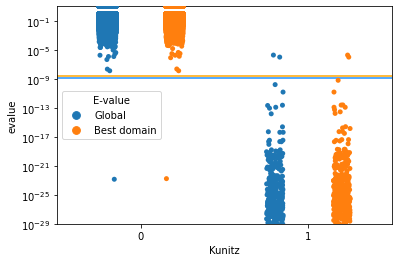

In [113]:
def plot_dataset(dataset):
    evalue_hit = pd.DataFrame({'evalue': dataset['Evalue hit']})
    evalue_hit['hit'] = 'Global'
    evalue_domain = pd.DataFrame({'evalue': dataset['Evalue best domain']})
    evalue_domain['hit'] = 'Best domain'
    final = [evalue_hit, evalue_domain]
    final = pd.concat(final)
    print(final)
    plot = sns.stripplot(y =final.evalue, x=dataset.Kunitz, hue = final.hit, dodge=True, data=dataset)
    plot.set(yscale='log', ylim=(10e-30,10))
    legend = plot.get_legend()
    legend.set_title('E-value')
   
    plot.axhline(1.43387082e-9, color = 'dodgerblue')
    plot.axhline(2.54107082e-9, color = 'orange')
    plt.savefig("whole_plot.png")
    return plot
plot_dataset(dataset)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(dataset['Evalue best domain'], 
                                                    dataset['Kunitz'], 
                                                    test_size=0.5, 
                                                    random_state=42)

In [65]:
def train_model(X, y):
    y_true = y
    scores_list = []
    for i in np.arange(-20, 1, 0.5):
        y_pred = X.apply(lambda x: 1 if x <10**(i) else 0)
        mcc_i = matthews_corrcoef(y_true, y_pred)
        acc_i = accuracy_score(y_true, y_pred)
        scores_list.append((i, mcc_i, acc_i))
        print('E-value = 10e', i, ' MCC: ', mcc_i, ' ACC: ', acc_i, sep = '')
        y_pred = y_pred.iloc[0:0]
    best_evalue_list = []
    best_mcc = scores_list[0][1]
    best_acc = scores_list[0][2]
    for record in scores_list:
        mcc = record[1]
        acc = record[2]
        if mcc > best_mcc:
            best_evalue_list.clear()
            best_evalue_list.append(record[0])
            best_mcc = mcc
            best_acc = acc
        elif mcc == best_mcc:
            best_evalue_list.append(record[0])
    best_evalue = np.mean(best_evalue_list) 
    print('Best E-value is:', 10**best_evalue)
    print('Train MCC:', best_mcc)
    print('Train ACC:', best_acc)
    return 10**best_evalue

In [53]:
threshold = train_model(X_train, y_train)

E-value = 10e-20.0 MCC: 0.9121576861657871 ACC: 0.9998977298244288
E-value = 10e-19.5 MCC: 0.9397599743443571 ACC: 0.9999288555300374
E-value = 10e-19.0 MCC: 0.9627907645630769 ACC: 0.9999555347062734
E-value = 10e-18.5 MCC: 0.9684630780720994 ACC: 0.9999622045003324
E-value = 10e-18.0 MCC: 0.9684630780720994 ACC: 0.9999622045003324
E-value = 10e-17.5 MCC: 0.9722262766421395 ACC: 0.9999666510297051
E-value = 10e-17.0 MCC: 0.9759749983393432 ACC: 0.9999710975590776
E-value = 10e-16.5 MCC: 0.9778439824165881 ACC: 0.999973320823764
E-value = 10e-16.0 MCC: 0.9815712994063335 ACC: 0.9999777673531367
E-value = 10e-15.5 MCC: 0.9834296726881433 ACC: 0.9999799906178231
E-value = 10e-15.0 MCC: 0.9834296726881433 ACC: 0.9999799906178231
E-value = 10e-14.5 MCC: 0.9834296726881433 ACC: 0.9999799906178231
E-value = 10e-14.0 MCC: 0.9834296726881433 ACC: 0.9999799906178231
E-value = 10e-13.5 MCC: 0.9852845490901613 ACC: 0.9999822138825094
E-value = 10e-13.0 MCC: 0.9871359483248637 ACC: 0.9999844371471

In [41]:
#plot = plot_dataset(pd.concat([X_train, y_train]))

In [60]:
def test_model(X, y, threshold):
    y_true = y
    y_pred = pd.Series([], dtype = 'category')
    y_pred = X.apply(lambda x: 1 if x < threshold else 0)
    mismatches = y_pred[y_pred != y_true] 
    mcc = matthews_corrcoef(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    false_negatives = list(mismatches[mismatches==0].index)
    false_positives = list(mismatches[mismatches==1].index)
    print('False negatives are:', false_negatives)
    print('False positives are:', false_positives)
    graph = sns.stripplot(y = X, x = y)
    graph.set(yscale='log', ylim=(10e-25,10))
    graph.axhline(threshold)
    print(confusion_matrix(y_true, y_pred))
    return(mcc, acc)

False negatives are: []
False positives are: []


array([[280943,      0],
       [     0,    175]])

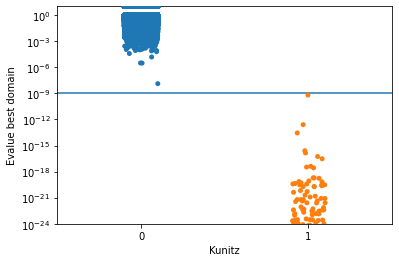

In [43]:
test_model(X_test, y_test, threshold)

<generator object _BaseKFold.split at 0x7fd2eeb36350>
TRAIN: [     0      1      2 ... 562233 562234 562235] TEST: [     3      9     19 ... 562213 562214 562217]
E-value = 10e-20.0 MCC: 0.9098173431265042 ACC: 0.9998955063274254
E-value = 10e-19.5 MCC: 0.9317065552390735 ACC: 0.9999199622933471
E-value = 10e-19.0 MCC: 0.9492413429314185 ACC: 0.9999399717200104
E-value = 10e-18.5 MCC: 0.9569316800463171 ACC: 0.9999488647985273
E-value = 10e-18.0 MCC: 0.9569316800463171 ACC: 0.9999488647985273
E-value = 10e-17.5 MCC: 0.9626592082190698 ACC: 0.999955534607415
E-value = 10e-17.0 MCC: 0.9683529381326086 ACC: 0.9999622044163028
E-value = 10e-16.5 MCC: 0.9702434403122194 ACC: 0.9999644276859321
E-value = 10e-16.0 MCC: 0.9740134624353269 ACC: 0.9999688742251905
E-value = 10e-15.5 MCC: 0.9796413566640179 ACC: 0.9999755440340783
E-value = 10e-15.0 MCC: 0.9796413566640179 ACC: 0.9999755440340783
E-value = 10e-14.5 MCC: 0.9796413566640179 ACC: 0.9999755440340783
E-value = 10e-14.0 MCC: 0.97964135

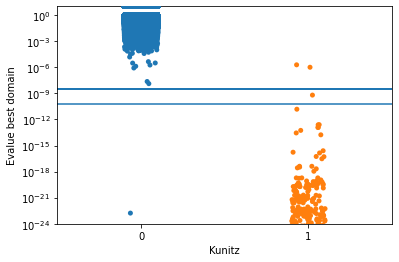

In [72]:
X = dataset['Evalue best domain']
y = dataset['Kunitz']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_splits = skf.get_n_splits
print(skf.split(X, y))
threshold_list = []
scores_list = []
for train_index, test_index in skf.split(X, y):    
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    threshold = train_model(X_train, y_train)
    threshold_list.append(threshold)
    mcc, acc = test_model(X_test, y_test, threshold)
    scores_list.append((mcc, acc))

    print('Test MCC:', mcc)
    print('Test ACC:', acc)
    average = np.mean(threshold_list)  


In [101]:
mcc = [col[0] for col in scores_list]
acc = [col[1] for col in scores_list]
avg_mcc = np.mean(mcc)
avg_acc = np.mean(acc)    
print('Average MCC:', avg_mcc)
print('Average ACC:', avg_acc)

Average MCC: 0.994146015207021
Average ACC: 0.9999928855371865


<generator object _BaseKFold.split at 0x7fd2ed01f040>
TRAIN: [     0      1      2 ... 562233 562234 562235] TEST: [     3      9     19 ... 562213 562214 562217]
E-value = 10e-20.0 MCC: 0.9198314236476631 ACC: 0.9999066226755716
E-value = 10e-19.5 MCC: 0.9511697431336071 ACC: 0.9999421949896395
E-value = 10e-19.0 MCC: 0.9588446487749434 ACC: 0.9999510880681566
E-value = 10e-18.5 MCC: 0.9645608439259603 ACC: 0.9999577578770443
E-value = 10e-18.0 MCC: 0.9664587465814813 ACC: 0.9999599811466735
E-value = 10e-17.5 MCC: 0.9721302746420036 ACC: 0.9999666509555613
E-value = 10e-17.0 MCC: 0.9758930248000411 ACC: 0.9999710974948198
E-value = 10e-16.5 MCC: 0.9758930248000411 ACC: 0.9999710974948198
E-value = 10e-16.0 MCC: 0.9815101673760518 ACC: 0.9999777673037076
E-value = 10e-15.5 MCC: 0.9833754350903126 ACC: 0.9999799905733368
E-value = 10e-15.0 MCC: 0.9833754350903126 ACC: 0.9999799905733368
E-value = 10e-14.5 MCC: 0.9833754350903126 ACC: 0.9999799905733368
E-value = 10e-14.0 MCC: 0.9833754

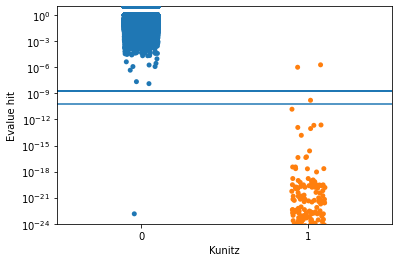

In [102]:
X = dataset['Evalue hit']
y = dataset['Kunitz']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_splits = skf.get_n_splits
print(skf.split(X, y))
threshold_list = []
scores_list = []
for train_index, test_index in skf.split(X, y):    
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    threshold = train_model(X_train, y_train)
    threshold_list.append(threshold)
    mcc, acc = test_model(X_test, y_test, threshold)
    scores_list.append((mcc, acc))

    print('Test MCC:', mcc)
    print('Test ACC:', acc)
    average = np.mean(threshold_list)  
 

In [103]:
mcc = [col[0] for col in scores_list]
acc = [col[1] for col in scores_list]
avg_mcc = np.mean(mcc)
avg_acc = np.mean(acc)    
print('Average MCC:', avg_mcc)
print('Average ACC:', avg_acc)

Average MCC: 0.994146015207021
Average ACC: 0.9999928855371865
